<a href="https://colab.research.google.com/github/gizdatalab/DPPD_Niger/blob/main/model_and_deviance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DPPD Find positive outlier in crop yields in Niger 

## Positive Deviance

In every community or organisation, a few individuals or groups use uncommon practices and behaviours to achieve better solutions to problems than their peers who face the same challenges and barriers. Those individuals are referred to as Positive Deviants and adopting their solutions is referred to as the Positive Deviance (PD) approach.​

Successful application in rehabilitating 50,000 children in vietnam​

Application of PD has been reported in more than 60 countries across the globe.​

Applications include: enhancing school retention & pregnancy outcomes, eliminating neonatal mortality, limiting HIV transmission, fighting against FGM.

# Import and transform data

## Upload data
(niger_landcover_prop.xlsx vill_dependent_var_mean.csv vill_savimax_mean.csv )

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

uploaded = files.upload()


In [2]:
!ls

niger_landcover_prop.xlsx  vill_dependent_var_mean.csv
sample_data		   vill_savimax_mean.csv


In [3]:
df1 = pd.read_csv('vill_savimax_mean.csv')
df2 = pd.read_csv('vill_dependent_var_mean.csv')
df3 = pd.read_excel('niger_landcover_prop.xlsx')

## merge savi and et/ pr/ ssm

In [4]:
df = df1[['savimax_2016', 'savimax_2017', 'savimax_2018', 'savimax_2019', 'savimax_2020','Village']].merge(
    df2,on='Village')
#.merge(df3[['class_111', 'class_20', 'class_30', 'class_40', 'class_50', 'class_60', 'class_80', 'class_90', 'Village']],on='Village')
df.shape,df1.shape,df2.shape,df3.shape

((12093, 100), (12093, 10), (12093, 95), (12093, 14))

In [5]:
df[:2]

savimax_2016  ...                                               .geo
0      0.621082  ...  {"type":"Polygon","coordinates":[[[4.066436957...
1      0.642015  ...  {"type":"Polygon","coordinates":[[[4.070650005...

[2 rows x 100 columns]

## Descriptive Stats

In [6]:
def describe_full(df):
    #pd.options.display.float_format = '{:.2f}'.format
    dtypes_description=pd.DataFrame(dict(df.dtypes),["dtypes"])
    na_description = pd.DataFrame(dict(df.isna().sum()),["NA-s"])
    na_percent = ((pd.DataFrame(dict(df.isna().sum()),["NA%"])/len(df))*100).round(decimals=2)
    description = df.describe(include='all')
    full_description = dtypes_description.append(na_description).append(na_percent).append(description).replace(np.nan, '', regex=True)

    mask = full_description.loc["freq",:]==1
    full_description.at[["top"],mask.index[mask]]=""
    #TODO: scientific notation - could be nicer
    
    return full_description

In [7]:
describe_full(df)

savimax_2016 savimax_2017  ... ssm_sum_2020-09    .geo
dtypes      float64      float64  ...         float64  object
NA-s            912          912  ...               3       0
NA%            7.54         7.54  ...            0.02       0
count         11181        11181  ...           12090   12093
unique                            ...                   12093
top                               ...                        
freq                              ...                       1
mean       0.507607     0.567885  ...         67.5937        
std        0.142846     0.119919  ...         28.9693        
min        0.141443     0.181674  ...         23.4485        
25%        0.400304     0.486796  ...         47.3908        
50%        0.492312     0.553878  ...         63.4057        
75%        0.596281     0.631514  ...         79.1461        
max         1.15636      1.14646  ...         202.801        

[14 rows x 100 columns]

## Map

In [8]:
%%capture
!pip install shapely
!pip install fiona 
!pip install descartes
!pip install rasterio 
!pip install folium 
!pip install earthengine-api
!pip install geemap 


In [9]:
from shapely.geometry import shape
import json
df['geometry'] = df['.geo'].apply(lambda x: shape(json.loads(x)))

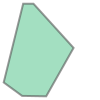

In [10]:
df['geometry'].iloc[4]

## Transform
In our raw table variables are split by years (max_savi_2016,max_savi_2017..) but we want to model max_savi (and may have the year as an independet variable). This will extend the dataframe five times (no of years) and decrease the the amount of variables (only for time dependent variables).

In [11]:
df.shape

(12093, 101)

In [12]:
years = ['2016','2017','2018','2019','2020']

Create a empty dataframe and fill with all villages x years. Loop through years and append the list of villages.

In [13]:
villages_list = []
year_list = []
for year in years:
    villages_list += [df['Village'].iloc[i] for i in range(0,len(df))]
    year_list += [ year for i in range(0,len(df))]

In [14]:
# dictionary of lists  
dict_ = {'Village': villages_list, 'year': year_list}  
    
df_new = pd.DataFrame(dict_) 
df_new[:4]  

Village  year
0     3579  2016
1     3580  2016
2     3581  2016
3     3582  2016

In [15]:
df_trans= pd.DataFrame()

for year in years:
    print(year)
    #find time depended variables for year x
    df_year = df[[col for col in df.columns if year in col]]
    #create column year
    df_year['year'] = [ year for i in range(0,len(df))] 
    #create column village
    df_year['Village'] = df['Village']
    #rename variables by exluding year (max_savi_2020 -> max_savi_)
    df_year.columns = [col.replace(year,'').replace('-','') for col in df_year.columns]
    print(df_year.shape)
    #merge empty base dataframe with yearly subset
    df_new_year = df_new[df_new['year']==year].merge(df_year,on=['Village','year'],how='left')
    #remove columns with NA (other years, will be filled in an other round of the loop)
    df_new_year[df_new_year['year'].isna()==False]
    #df_new_year = df_new_year.dropna()
    print('df_new',df_new.shape,'df_new_year',df_new_year.shape)
    #append year specific data 
    df_trans = df_trans.append(df_new_year)
    print('df_trans',df_trans.shape)
    print()

2016
(12093, 21)
df_new (60465, 2) df_new_year (12093, 21)
df_trans (12093, 21)

2017
(12093, 21)
df_new (60465, 2) df_new_year (12093, 21)
df_trans (24186, 21)

2018
(12093, 21)
df_new (60465, 2) df_new_year (12093, 21)
df_trans (36279, 21)

2019
(12093, 21)
df_new (60465, 2) df_new_year (12093, 21)
df_trans (48372, 21)

2020
(12093, 21)
df_new (60465, 2) df_new_year (12093, 21)
df_trans (60465, 21)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

The new shape is (55043, 38) compared to (12093, 100) before. Observation per year are similarly distributed.

In [16]:
print(df_trans.shape)
df_trans['year'].value_counts()

(60465, 21)


2020    12093
2016    12093
2018    12093
2019    12093
2017    12093
Name: year, dtype: int64

## Merge time independend variables

In [17]:
df3.columns

Index(['system:index', 'SS_GROUP', 'Surface', 'Village', 'class_111',
       'class_20', 'class_30', 'class_40', 'class_50', 'class_60', 'class_80',
       'class_90', 'total', '.geo'],
      dtype='object')

In [18]:
df_trans = df_trans.merge(df3[['class_111', 'class_20', 'class_30', 'class_40', 'class_50', 'class_60', 'class_80', 'class_90','Surface', 'Village']],on='Village')

## Dummies for categorical (years)

In [19]:
df_trans = df_trans.merge(pd.get_dummies(data=df_trans['year'],prefix='year', drop_first=True),how='left', left_index=True, right_index=True)

## NAs

45% aller Observationen beinhalten NAs

In [20]:
(df_trans.shape[0] - df_trans.dropna().shape[0]) / df_trans.shape[0] 

0.45361779541883734

The variable with the highest amount of NAs is et_sum_06 (21%)

In [21]:
(df_trans['et_sum_06'].shape[0] - df_trans['et_sum_06'].dropna().shape[0]) / df_trans['et_sum_06'].shape[0] 

0.22085504010584636

In [22]:
df_na = df_trans[df_trans['et_sum_06'].isna()==True]
df_na[:3]

Village  year  savimax_  ...  year_2018  year_2019  year_2020
25     3584  2016  0.509978  ...          0          0          0
27     3584  2018  0.636607  ...          1          0          0
29     3584  2020  0.571365  ...          0          0          1

[3 rows x 34 columns]

Impute Zero, Mean, Reg or Exclude?

In [23]:
# drop observation with missing savi
df_trans = df_trans[df_trans['savimax_'].isna()==False]
#df_trans = df_trans[df_trans['et_sum_'].isna()==False]
#df_trans = df_trans[df_trans['ssm_sum_'].isna()==False]


In [24]:
#df_trans = df_trans[df_trans['et_sum_06'].isna()==False]
#df_trans = df_trans[df_trans['et_sum_06'].isna()==False]
#df_trans = df_trans[df_trans['et_sum_06'].isna()==False]
#df_trans = df_trans[df_trans['et_sum_06'].isna()==False]

In [25]:
#For now mean- impute
#df_trans['et_sum_06'] = df_trans['et_sum_06'].fillna((df_trans['et_sum_06'].mean()), inplace=True)
#df_trans['et_sum_07'] = df_trans['et_sum_07'].fillna((df_trans['et_sum_07'].mean()), inplace=True)
#df_trans['et_sum_08'] = df_trans['et_sum_08'].fillna((df_trans['et_sum_08'].mean()), inplace=True)
#df_trans['et_sum_09'] = df_trans['et_sum_09'].fillna((df_trans['et_sum_09'].mean()), inplace=True)

df_trans['et_sum_06'] = df_trans['et_sum_06'].fillna(0)
df_trans['et_sum_07']  = df_trans['et_sum_07'].fillna(0)
df_trans['et_sum_08']  = df_trans['et_sum_08'].fillna(0)
df_trans['et_sum_09']  = df_trans['et_sum_09'].fillna(0)

## Feature Engeneering

In [26]:
df_trans['et_sum__sum'] = df_trans['et_sum_06'] + df_trans['et_sum_07']+df_trans['et_sum_08']+df_trans['et_sum_09']
df_trans['et_sum__sum2'] = df_trans['et_sum__sum'] **2
df_trans['et_sum__log'] = np.log(df_trans['et_sum__sum'] +1)
df_trans['et_sum__log2'] = df_trans['et_sum__log'] **2


df_trans['pr_sum__sum'] = df_trans['pr_sum_06'] + df_trans['pr_sum_07']+df_trans['pr_sum_08']+df_trans['pr_sum_09']
df_trans['pr_sum__sum2'] = df_trans['pr_sum__sum'] **2
df_trans['pr_sum__log'] = np.log(df_trans['pr_sum__sum'] +1)
df_trans['pr_sum__log2'] = df_trans['pr_sum__log'] **2
df_trans['pr_et_interact'] = df_trans['pr_sum__sum'] / df_trans['et_sum__sum']


df_trans['ssm_sum__sum'] = df_trans['ssm_sum_06'] + df_trans['ssm_sum_07']+df_trans['ssm_sum_08']+df_trans['ssm_sum_09']
df_trans['ssm_sum__sum2'] = df_trans['ssm_sum__sum'] **2
df_trans['ssm_sum__log'] = np.log(df_trans['ssm_sum__sum'] +1)
df_trans['ssm_sum__log2'] = df_trans['ssm_sum__log'] **2


## Descriptives again & Plots

In [27]:
#describe_full(df_trans)

In [28]:
# import matplotlib
import matplotlib.pyplot as plt
# import seaborn
import seaborn as sns
%matplotlib inline

### Mean Evapotranspiration Boxplot

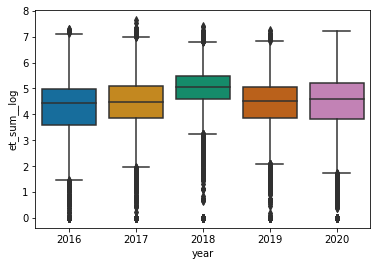

In [29]:
sns.boxplot(y='et_sum__log', x='year', 
                 data=df_trans, 
                 palette="colorblind")
                 #hue='year')


### Mean Precipitation Boxplot

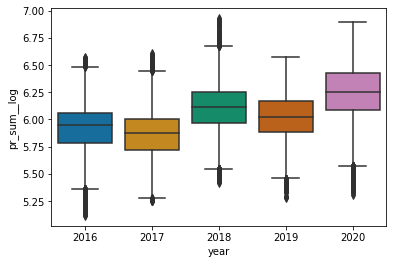

In [30]:
sns.boxplot(y='pr_sum__log', x='year', 
                 data=df_trans, 
                 palette="colorblind")
                 #hue='year')


### Mean Carbon Soil Boxplot

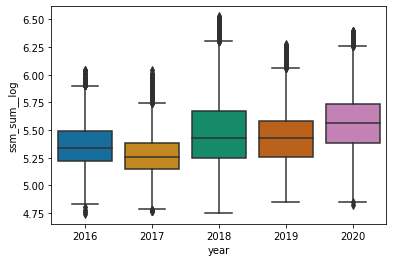

In [31]:
sns.boxplot(y='ssm_sum__log', x='year', 
                 data=df_trans, 
                 palette="colorblind")
                 #hue='year')


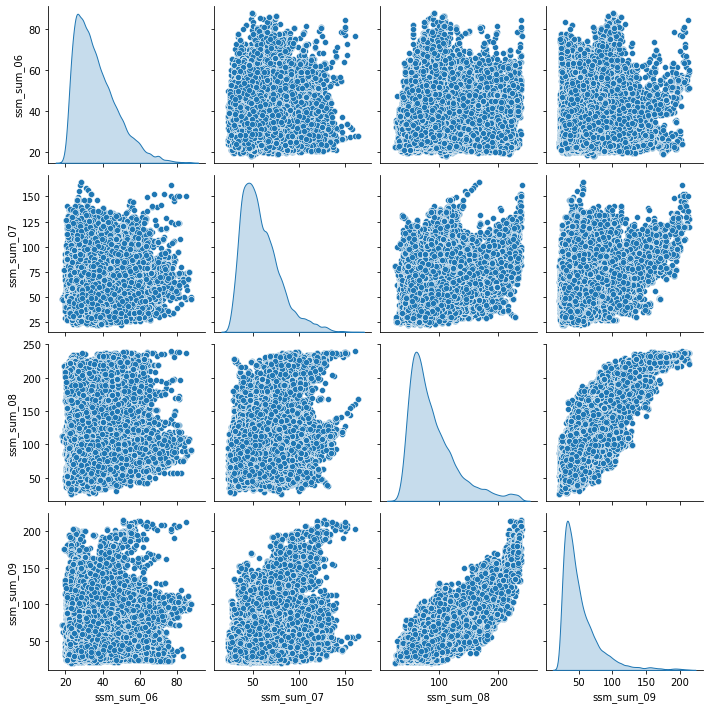

In [32]:
sns.pairplot(df_trans[['ssm_sum_06', 'ssm_sum_07', 'ssm_sum_08', 'ssm_sum_09']], diag_kind='kde')

### Max Savi Boxplot

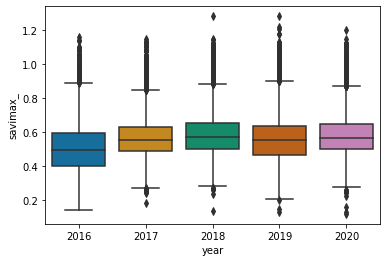

In [33]:
sns.boxplot(y='savimax_', x='year', 
                 data=df_trans, 
                 palette="colorblind")
                 #hue='year')


### Scatter savi vs. pr

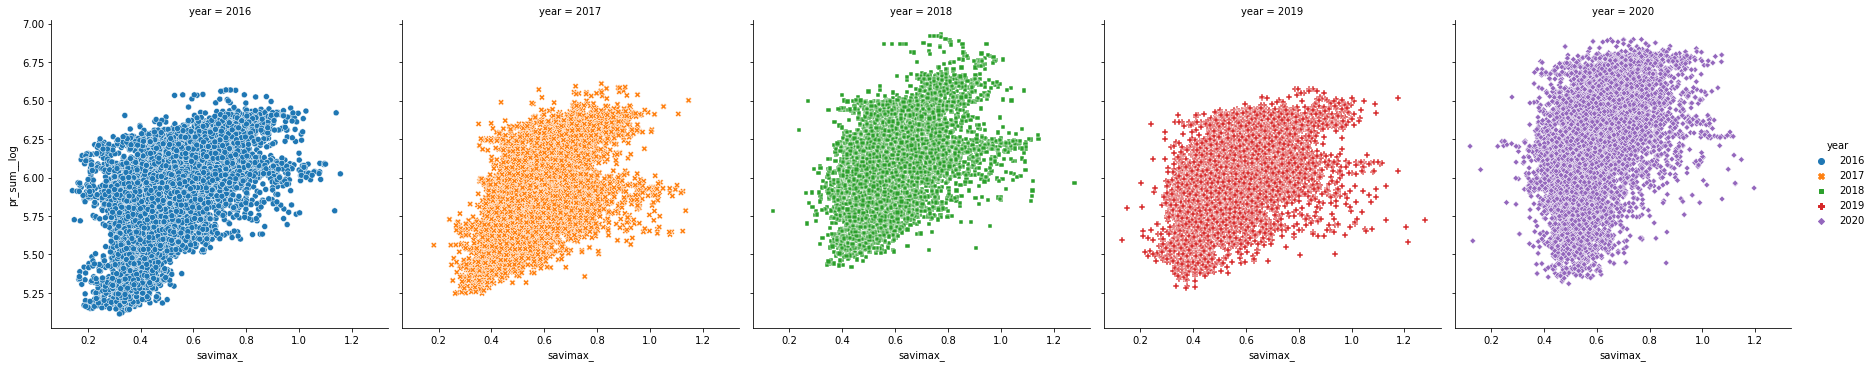

In [34]:
sns.relplot(
    data=df_trans, x="savimax_", y="pr_sum__log",
    col="year", hue="year", style="year",
    kind="scatter"
)

### Scatter savi vs. et

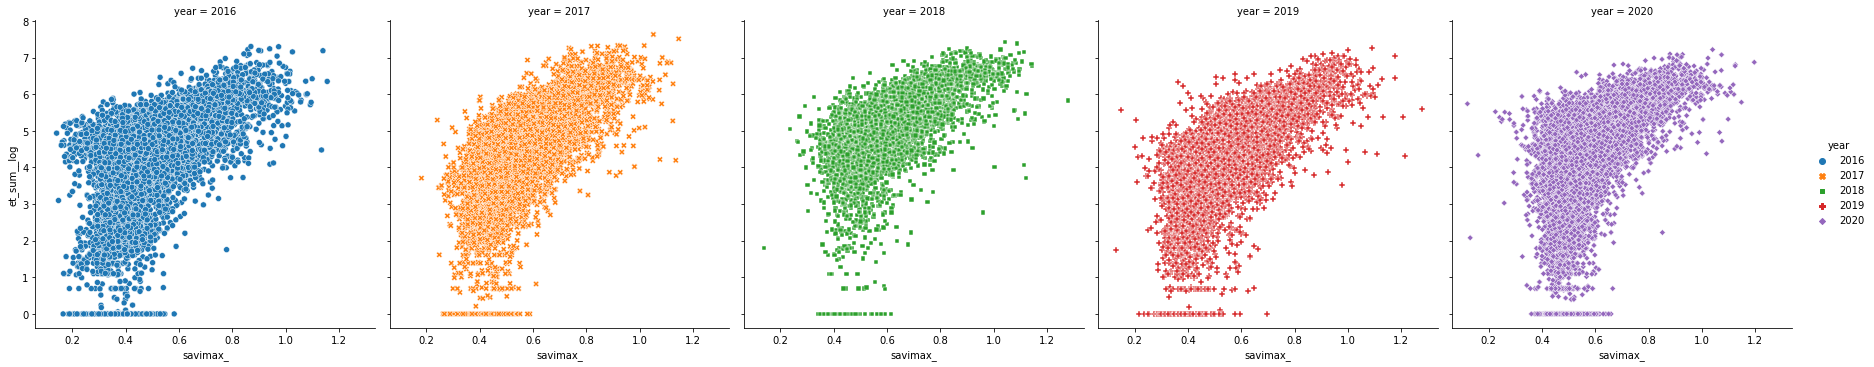

In [35]:
sns.relplot(
    data=df_trans, x="savimax_", y="et_sum__log",
    col="year", hue="year", style="year",
    kind="scatter"
)

### Scatter savi vs. soil

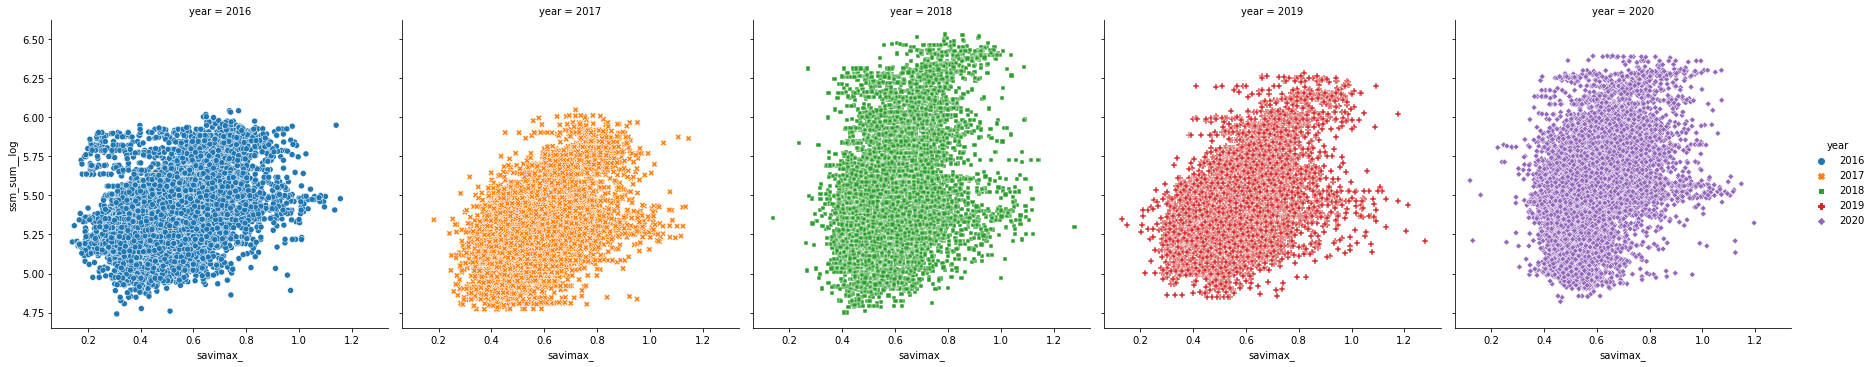

In [36]:
sns.relplot(
    data=df_trans, x="savimax_", y="ssm_sum__log",
    col="year", hue="year", style="year",
    kind="scatter"
)

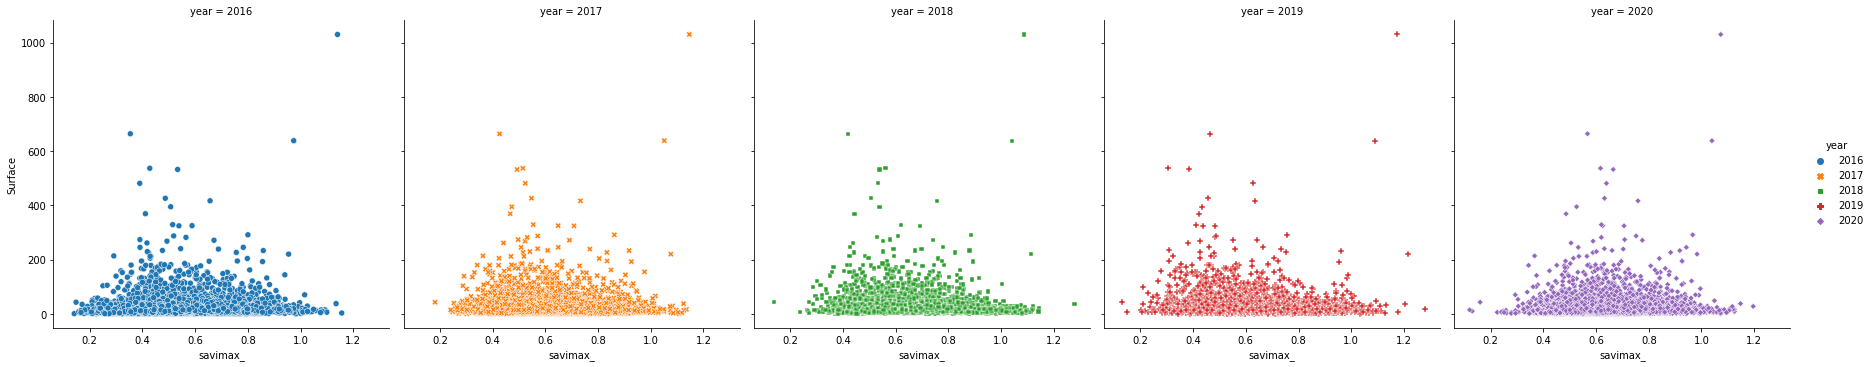

In [37]:
sns.relplot(
    data=df_trans, x="savimax_", y="Surface",
    col="year", hue="year", style="year",
    kind="scatter"
)



In [38]:
df_trans[['savimax_','pr_mean_','et_mean_','ssm_mean_']].corr()

savimax_  pr_mean_  et_mean_  ssm_mean_
savimax_   1.000000  0.461101  0.540367   0.398291
pr_mean_   0.461101  1.000000  0.573838   0.731131
et_mean_   0.540367  0.573838  1.000000   0.507883
ssm_mean_  0.398291  0.731131  0.507883   1.000000

In [39]:
df_trans[['savimax_','pr_sum_','et_sum_','ssm_sum_','Surface']].corr()

savimax_   pr_sum_   et_sum_  ssm_sum_   Surface
savimax_  1.000000  0.461101  0.662599  0.397971  0.052733
pr_sum_   0.461101  1.000000  0.433565  0.732968 -0.039471
et_sum_   0.662599  0.433565  1.000000  0.449273  0.107811
ssm_sum_  0.397971  0.732968  0.449273  1.000000  0.020071
Surface   0.052733 -0.039471  0.107811  0.020071  1.000000

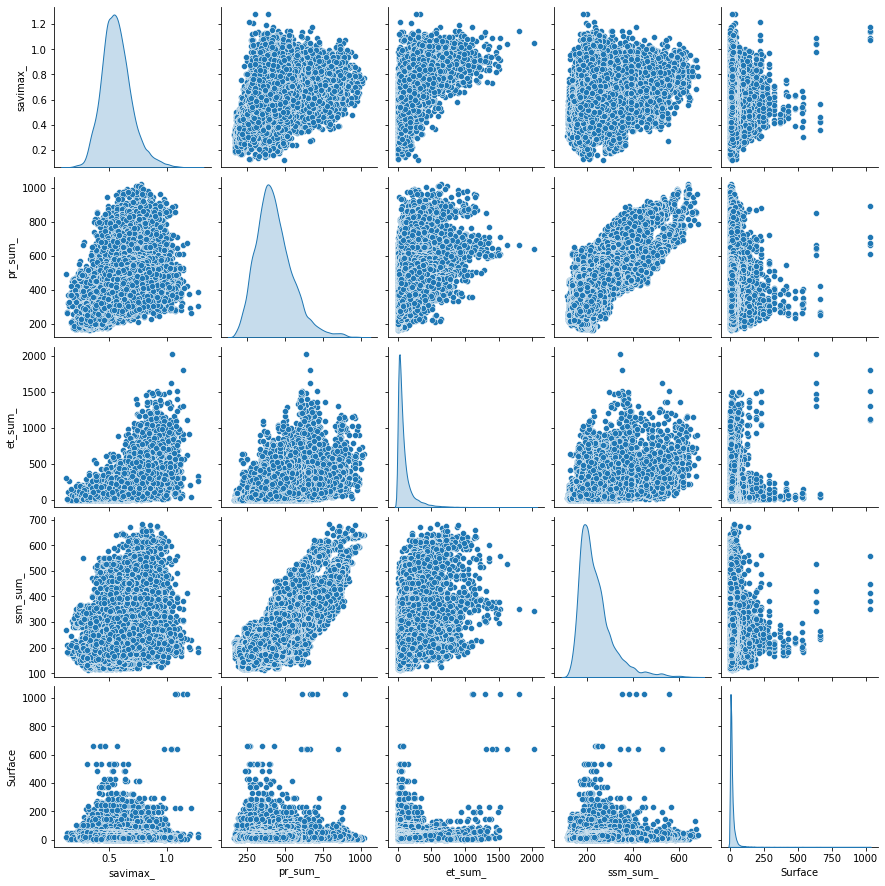

In [40]:
sns.pairplot(df_trans[['savimax_','pr_sum_','et_sum_','ssm_sum_','Surface']], diag_kind='kde')

# Clustering

In [41]:
# for clustering:
from sklearn.cluster import KMeans
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec


In [42]:
df_trans[df_trans['et_mean_'].isna()==True].Village.value_counts()

11968    5
11986    5
11950    5
11951    5
11952    5
        ..
9838     1
9839     1
627      1
630      1
11546    1
Name: Village, Length: 600, dtype: int64

Look for "Elbow"-point to determin the number of clusters

In [43]:
df_trans.columns

Index(['Village', 'year', 'savimax_', 'et_mean_', 'et_sum_', 'et_sum_06',
       'et_sum_07', 'et_sum_08', 'et_sum_09', 'pr_mean_', 'pr_sum_',
       'pr_sum_06', 'pr_sum_07', 'pr_sum_08', 'pr_sum_09', 'ssm_mean_',
       'ssm_sum_', 'ssm_sum_06', 'ssm_sum_07', 'ssm_sum_08', 'ssm_sum_09',
       'class_111', 'class_20', 'class_30', 'class_40', 'class_50', 'class_60',
       'class_80', 'class_90', 'Surface', 'year_2017', 'year_2018',
       'year_2019', 'year_2020', 'et_sum__sum', 'et_sum__sum2', 'et_sum__log',
       'et_sum__log2', 'pr_sum__sum', 'pr_sum__sum2', 'pr_sum__log',
       'pr_sum__log2', 'pr_et_interact', 'ssm_sum__sum', 'ssm_sum__sum2',
       'ssm_sum__log', 'ssm_sum__log2'],
      dtype='object')

In [44]:
agg_y = ['et_sum_', 'pr_sum_','ssm_sum_']
build_up = ['class_111', 'class_20', 'class_30', 'class_40', 'class_50', 'class_60', 'class_80','class_90','Surface']
agg_m = ['et_sum_06', 'et_sum_07','et_sum_08', 'et_sum_09','pr_sum_06', 'pr_sum_07','pr_sum_08', 'pr_sum_09','ssm_sum_06', 'ssm_sum_07', 'ssm_sum_08', 'ssm_sum_09']

In [45]:
# Shrub, (20)
# Herbaceous vegetation, (30)
# Cultivated and managed vegetation / agriculture (40)
# Settlements (50)
# bare/sparse vegetation (60)
# open water (80)
# Herbaceous wetland (90)
# Closed forest (111-126)

In [46]:
df_trans[build_up].describe()

class_111      class_20  ...      class_90       Surface
count  55905.000000  55905.000000  ...  55905.000000  55905.000000
mean       0.002594      0.088587  ...      0.003156     18.759281
std        0.011053      0.153928  ...      0.025217     28.321540
min        0.000000      0.000000  ...      0.000000      0.542091
25%        0.000000      0.000912  ...      0.000000      7.206820
50%        0.000000      0.019842  ...      0.000000     11.507900
75%        0.000190      0.101619  ...      0.000000     20.560600
max        0.282038      0.963293  ...      0.594705   1029.710000

[8 rows x 9 columns]

In [47]:
df_trans[build_up].corr()

class_111  class_20  class_30  ...  class_80  class_90   Surface
class_111   1.000000  0.333306 -0.041190  ...  0.123564  0.136879  0.026060
class_20    0.333306  1.000000 -0.083608  ...  0.083343  0.075760  0.118917
class_30   -0.041190 -0.083608  1.000000  ...  0.010226 -0.014122  0.239032
class_40   -0.147594 -0.347305 -0.876205  ... -0.119088 -0.107535 -0.316347
class_50    0.052458 -0.003667 -0.031330  ...  0.055508  0.033696 -0.024604
class_60   -0.014136 -0.090199  0.270936  ...  0.000009 -0.012382  0.304298
class_80    0.123564  0.083343  0.010226  ...  1.000000  0.646883 -0.026011
class_90    0.136879  0.075760 -0.014122  ...  0.646883  1.000000 -0.030459
Surface     0.026060  0.118917  0.239032  ... -0.026011 -0.030459  1.000000

[9 rows x 9 columns]

## PCA

In [48]:
 
#for scaling/PCA:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [49]:
build_up = ['class_111', 'class_20', 'class_30', 'class_50', 'class_60', 'class_80','class_90','Surface'] #'class_40', 

In [50]:
scaler = StandardScaler()

#First, create Ruralness Index:
df_unscaled_Ruralness = df_trans[build_up]
df_scaled_Ruralness = pd.DataFrame(scaler.fit_transform(df_unscaled_Ruralness), columns = build_up)

pca_ = PCA(3, random_state = 42)
pca_.fit(df_scaled_Ruralness)
variance_explained_Ruralness = pca_.explained_variance_ratio_
print(variance_explained_Ruralness*100)

[22.14347961 19.22887682 15.88810987]


In [51]:
PPCCAA = pca_.transform(df_scaled_Ruralness)

In [52]:
df_trans['pca1'] = PPCCAA[:,0]
df_trans['pca2'] = PPCCAA[:,1]
df_trans['pca3'] = PPCCAA[:,2]

(55043, 50)


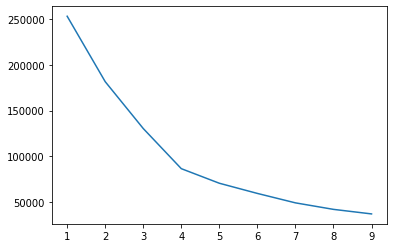

In [53]:
#build_up = ['class_111', 'class_20', 'class_30',  'class_50', 'class_60', 'class_80','class_90','Surface']
pcas = ['pca1', 'pca2', 'pca3']
cluster_var = pcas

df_trans = df_trans[df_trans['et_mean_'].isna()==False]
df_trans = df_trans[df_trans['ssm_mean_'].isna()==False]
print(df_trans.shape)
#clust_df = df_trans[['pr_mean_', 'et_mean_','ssm_mean_']].copy()
clust_df = df_trans[cluster_var].copy()
#clust_df = clust_df[clust_df['ev_mean_'].isna()==False]
max_k=10
wcss=[]

for k in range(1,max_k):
  kmeans = KMeans(k)
  kmeans.fit(clust_df)
  wcss_iter = kmeans.inertia_  #Sum of squared distances of samples to their closest cluster center.
  wcss.append(wcss_iter)

number_of_clusters = range(1,max_k)
plt.plot(number_of_clusters,wcss)

        A 2-cluster solution would look like this:


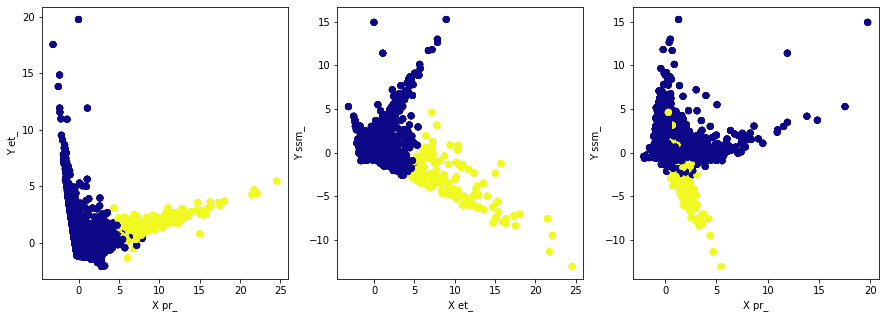

        A 3-cluster solution would look like this:


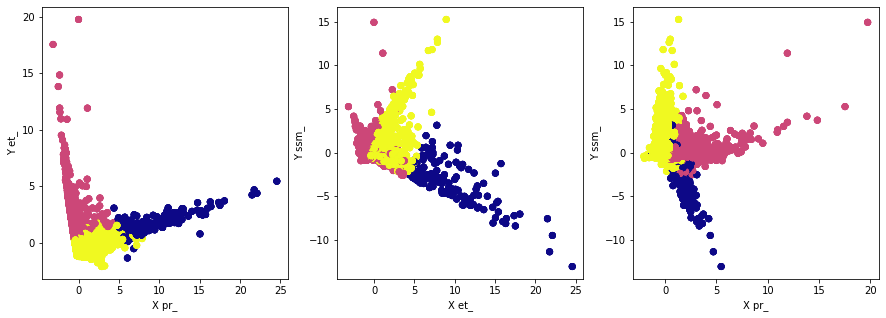

        A 4-cluster solution would look like this:


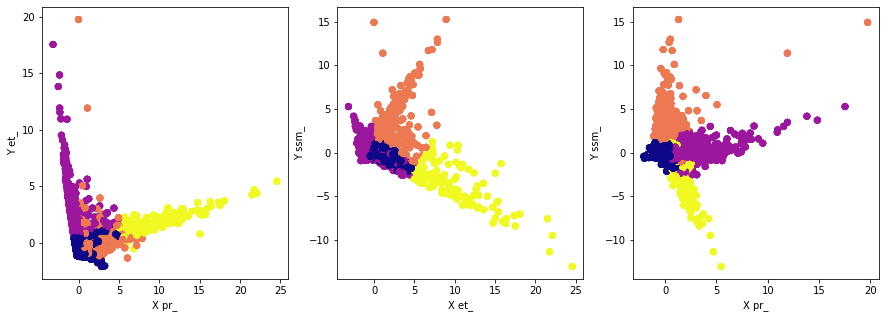

        A 5-cluster solution would look like this:


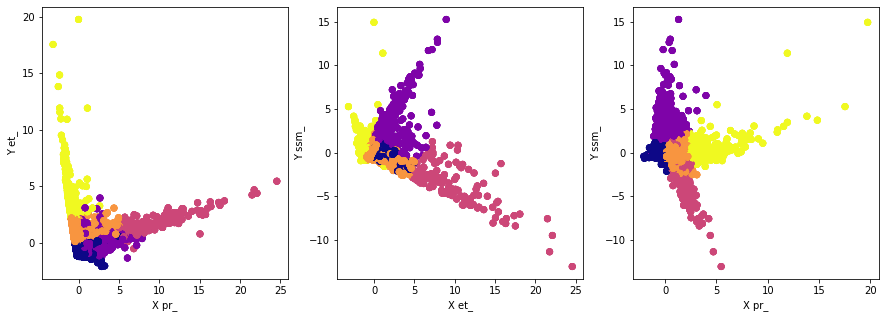

In [54]:
for k in range(2,6):
    kmeans = KMeans(k)
    identified_clusters = kmeans.fit_predict(clust_df)
    print('        A ' + str(k) +'-cluster solution would look like this:')
   # Create 2x2 sub plots
    gs = gridspec.GridSpec(1, 3)

    pl.figure(figsize=(15, 5))
    ax = pl.subplot(gs[0, 0]) # row 0, col 0
    pl.scatter(clust_df[cluster_var[0]],clust_df[cluster_var[1]],
                c=identified_clusters,cmap='plasma')
    ax.set_xlabel('X pr_')
    ax.set_ylabel('Y et_')

    ax = pl.subplot(gs[0, 1]) # row 0, col 1
    pl.scatter(clust_df[cluster_var[0]],clust_df[cluster_var[2]],
                c=identified_clusters,cmap='plasma')
    ax.set_xlabel('X et_')
    ax.set_ylabel('Y ssm_')

    ax = pl.subplot(gs[0, 2]) # row 1, span all columns
    pl.scatter(clust_df[cluster_var[1]],clust_df[cluster_var[2]],
                c=identified_clusters,cmap='plasma')
    ax.set_xlabel('X pr_')
    ax.set_ylabel('Y ssm_')

    pl.show()

In [55]:
kmeans = KMeans(4, random_state=42) 
#random state makes sure that cluster labels stay the same between executions
df_trans['cluster'] = kmeans.fit_predict(clust_df)
df_trans = df_trans.merge(pd.get_dummies(data=df_trans['cluster'],prefix='cluster', drop_first=True),how='left', left_index=True, right_index=True)
df_trans['cluster'].value_counts()

0    37807
1    12441
2     4190
3      605
Name: cluster, dtype: int64

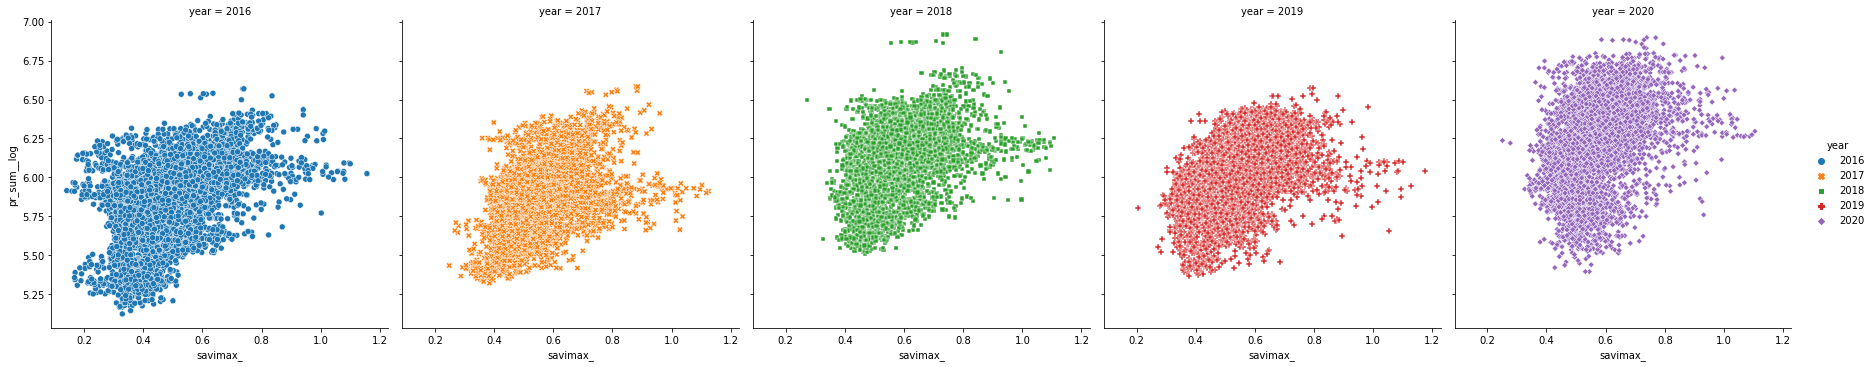

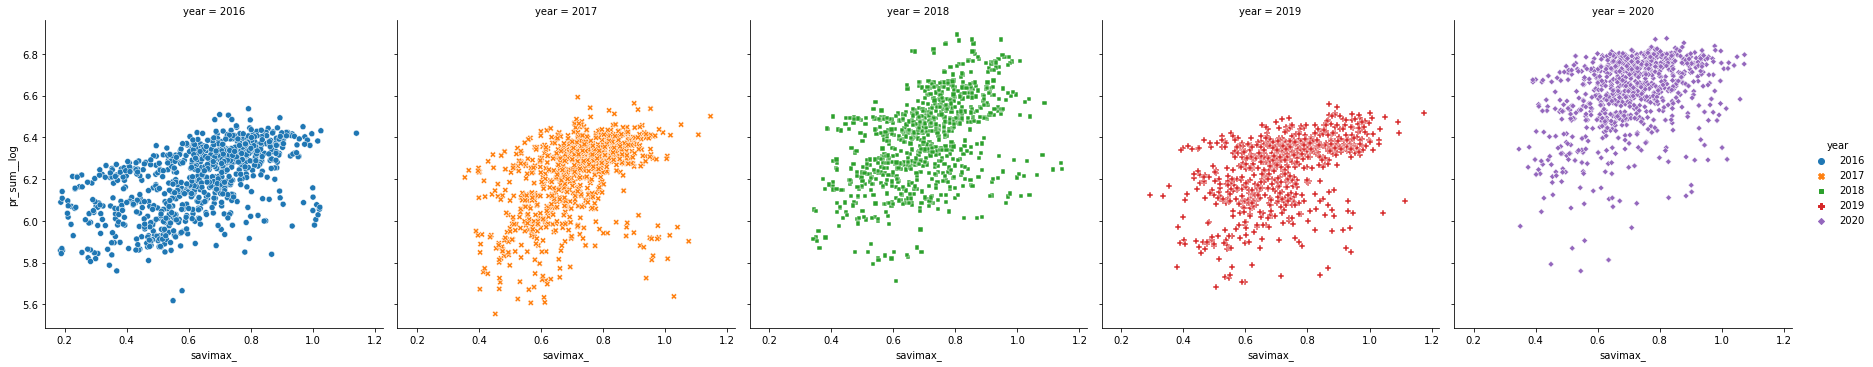

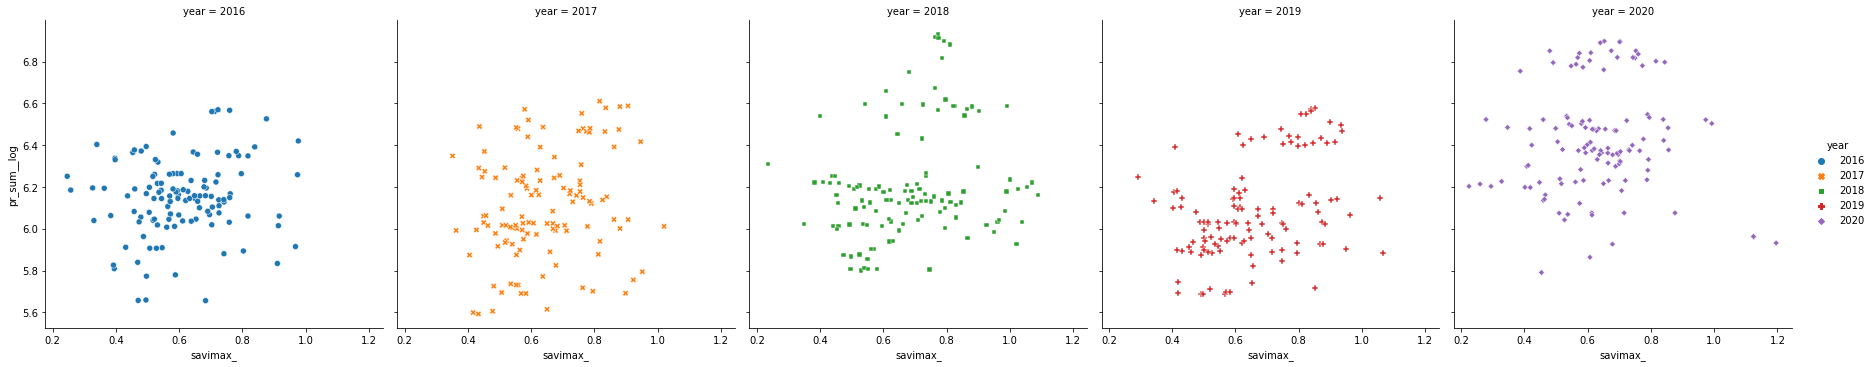

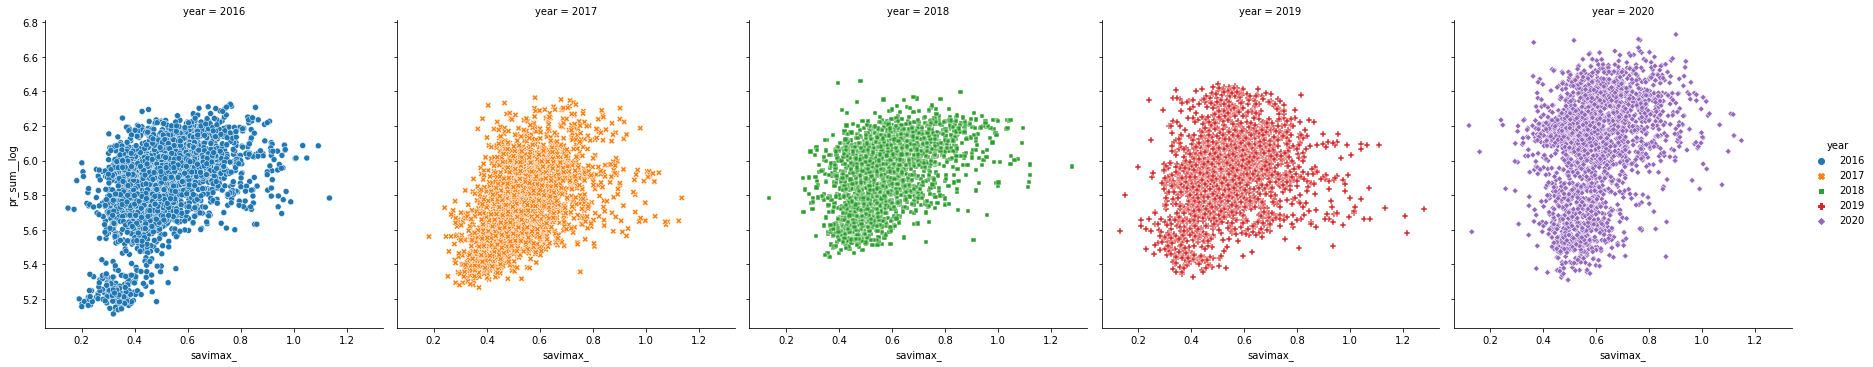

In [56]:
for cl in df_trans['cluster'].unique():
    sns.relplot(
        data=df_trans[df_trans['cluster']==cl], x="savimax_", y="pr_sum__log",
        col="year", hue="year", style="year",
        kind="scatter"
    )

## Standardize Data an Train / Test split

In [57]:
#for scaling/PCA:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [58]:
agg_y = [ 'pr_sum_','ssm_sum_']
years = [ 'year_2017', 'year_2018', 'year_2019', 'year_2020']
build_up = ['class_111', 'class_20', 'class_30', 'class_40', 'class_50', 'class_60', 'class_80','Surface']
agg_m = ['pr_sum_06', 'pr_sum_07','pr_sum_08', 'pr_sum_09','ssm_sum_06', 'ssm_sum_07', 'ssm_sum_08', 'ssm_sum_09']
cluster = ['cluster_1','cluster_2','cluster_3']
cl_var = ['cluster','year','savimax_','Village']

all = agg_y+ years+ build_up + agg_m + cluster +cl_var
all

['pr_sum_',
 'ssm_sum_',
 'year_2017',
 'year_2018',
 'year_2019',
 'year_2020',
 'class_111',
 'class_20',
 'class_30',
 'class_40',
 'class_50',
 'class_60',
 'class_80',
 'Surface',
 'pr_sum_06',
 'pr_sum_07',
 'pr_sum_08',
 'pr_sum_09',
 'ssm_sum_06',
 'ssm_sum_07',
 'ssm_sum_08',
 'ssm_sum_09',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster',
 'year',
 'savimax_',
 'Village']

In [59]:
from sklearn.model_selection import train_test_split
X = df_trans[all]
Y = df_trans['savimax_']

X_train_, X_val_test, y_train, y_val_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val_, X_test_, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

X_train_.shape,X_val_.shape,X_test_.shape

((44034, 29), (5504, 29), (5505, 29))

In [60]:
scaler = StandardScaler()
scaler.fit(X_train_)
X_train = pd.DataFrame(scaler.transform(X_train_), columns = all)
X_train.index = y_train.index
X_train['cluster'] = X_train_['cluster']
X_train['year'] = X_train_['year']
X_train['Village'] = X_train_['Village']
X_val = pd.DataFrame(scaler.transform(X_val_), columns = all)
X_val.index = y_val.index
X_val['cluster'] = X_val_['cluster']
X_val['year'] = X_val_['year']
X_val['Village'] = X_val['Village']
X_test = pd.DataFrame(scaler.transform(X_test_), columns = all)
X_test.index = y_test.index
X_test['cluster'] = X_test_['cluster']
X_test['year'] = X_test_['year']
X_test['Village'] = X_test['Village']

# Regression

In [61]:
#regression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [62]:
def scale_regress(Xtr,Ytr,Xte,Yte,return_model=False):
    #trian test split
    Xtr = sm.add_constant(Xtr) 

    model = sm.OLS(Ytr, Xtr,M=sm.robust.norms.HuberT()).fit()

    print_model = model.summary()
    print(print_model)

    Xte = sm.add_constant(Xte)

    metrics(model,Xtr,Xte,Ytr,Yte)

    sns.relplot(
        data=Ytr, x=Ytr, y=model.resid,
        kind="scatter"
    )
    if return_model:
        return model
 

In [63]:
def metrics(model,xtr,xte,ytr,yte):
    y_pred = model.predict(xtr)
    print('train MSE',mean_squared_error(ytr, y_pred))
    print('train MAE',mean_absolute_error(ytr, y_pred))
    print('train pR2',r2_score(ytr, y_pred))
    print()
    y_pred = model.predict(xte)
    print('test MSE',mean_squared_error(yte, y_pred))
    print('test MAE',mean_absolute_error(yte, y_pred))
    print('test pR2',r2_score(yte, y_pred))

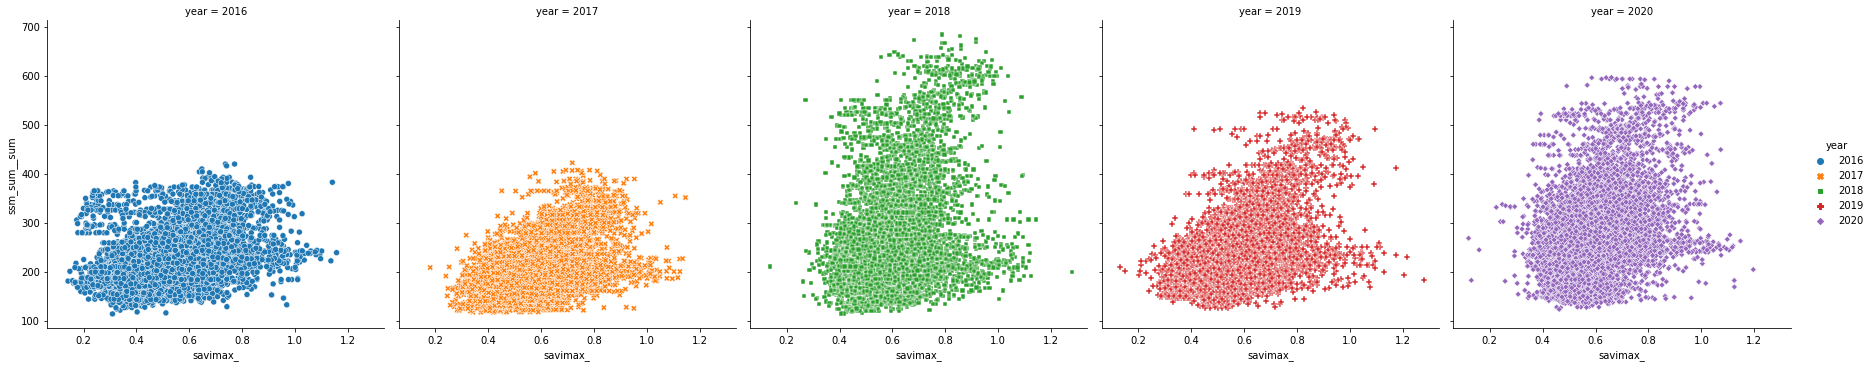

In [64]:
sns.relplot(
        data=df_trans, x="savimax_", y="ssm_sum__sum",
        col="year", hue="year", style="year",
        kind="scatter"
    )

                            OLS Regression Results                            
Dep. Variable:               savimax_   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     1543.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:18:45   Log-Likelihood:                 36005.
No. Observations:               44034   AIC:                        -7.198e+04
Df Residuals:                   44019   BIC:                        -7.185e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5634      0.001   1106.511      0.0

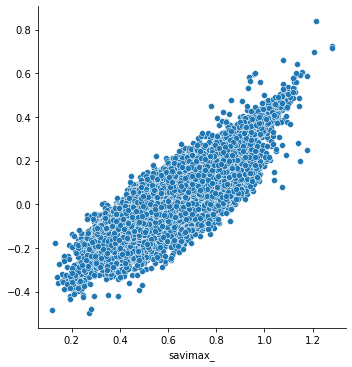

In [65]:
vars = years+  agg_y + build_up

scale_regress(X_train[vars],y_train,X_test[vars],y_test,False)

                            OLS Regression Results                            
Dep. Variable:               savimax_   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     1215.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:18:46   Log-Likelihood:                 36893.
No. Observations:               44034   AIC:                        -7.374e+04
Df Residuals:                   44013   BIC:                        -7.356e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5634      0.000   1128.962      0.0

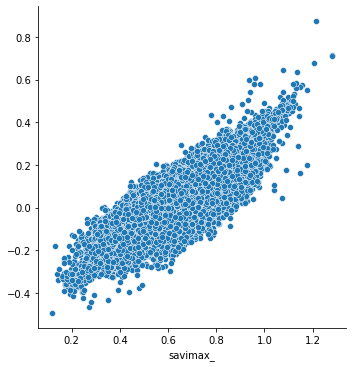

In [66]:
var_ols = years+  agg_m + build_up

ols = scale_regress(X_train[var_ols],y_train,X_test[var_ols],y_test,True)

Random Effects Model
https://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html

## Regression by Cluster

In [67]:
X_train['cluster'].unique()

array([0, 1, 2, 3], dtype=int32)


cluster  0

Obs  44034
                            OLS Regression Results                            
Dep. Variable:               savimax_   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     830.6
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:18:47   Log-Likelihood:                 29208.
No. Observations:               30262   AIC:                        -5.837e+04
Df Residuals:                   30241   BIC:                        -5.820e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5339      0

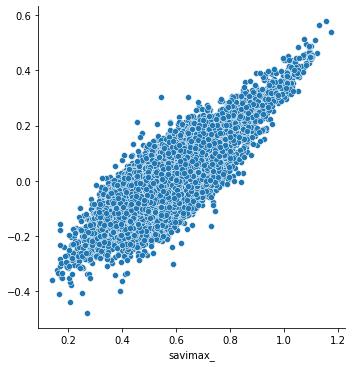

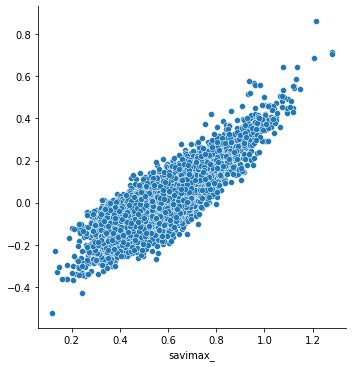

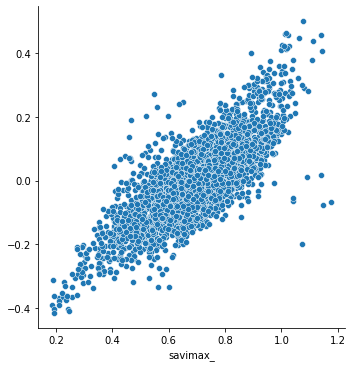

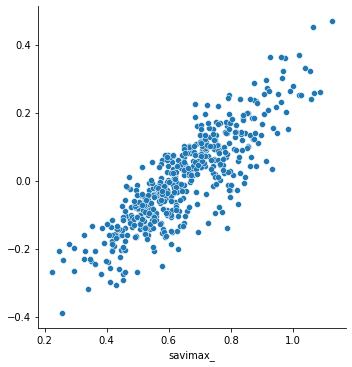

In [68]:
for i in X_train['cluster'].unique():
    print()
    print('cluster ',i)
    print()
    vars = years+  agg_m + build_up

    X_train_cl = X_train[X_train['cluster']==i]
    y_train_cl = y_train[X_train[X_train['cluster']==i].index]
    X_test_cl = X_test[X_test['cluster']==i]
    y_test_cl = y_test[X_test[X_test['cluster']==i].index]

    print('Obs ',len(X_train))

    scale_regress(X_train_cl[vars],y_train_cl,X_test_cl[vars],y_test_cl,True)



year  2018

Obs  44034
                            OLS Regression Results                            
Dep. Variable:               savimax_   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     347.3
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:18:49   Log-Likelihood:                 8277.0
No. Observations:                8838   AIC:                        -1.652e+04
Df Residuals:                    8821   BIC:                        -1.640e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5535      0

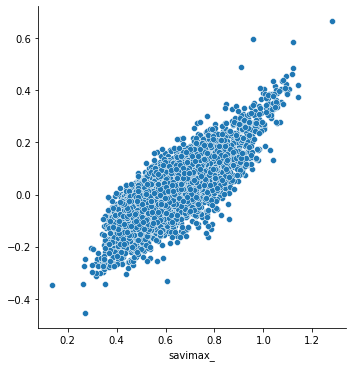

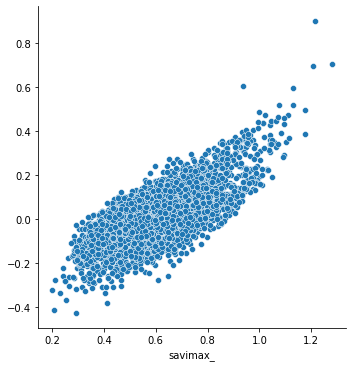

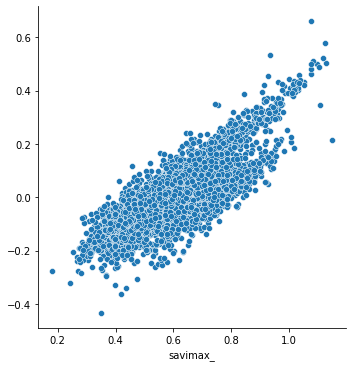

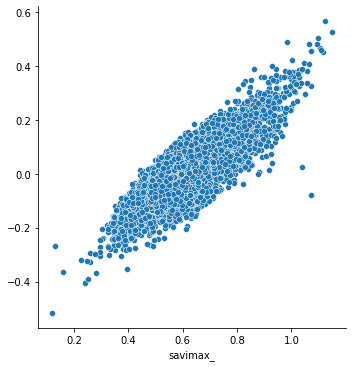

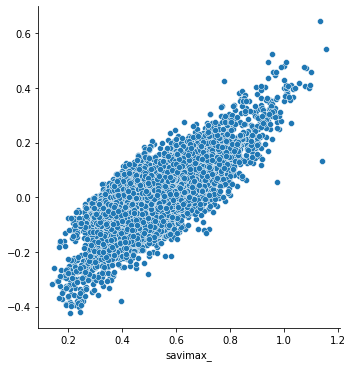

In [69]:
for i in X_train['year'].unique():
    print()
    print('year ',i)
    print()
    vars = agg_m + build_up

    X_train_cl = X_train[X_train['year']==i]
    y_train_cl = y_train[X_train[X_train['year']==i].index]
    X_test_cl = X_test[X_test['year']==i]
    y_test_cl = y_test[X_test[X_test['year']==i].index]

    print('Obs ',len(X_train))

    scale_regress(X_train_cl[vars],y_train_cl,X_test_cl[vars],y_test_cl,True)


## Mixed Effects Regression

In [70]:
agg_y

['pr_sum_', 'ssm_sum_']

In [71]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

vars = years+  agg_y + build_up

md = smf.mixedlm("savimax_ ~ pr_sum_ + ssm_sum_ ", X_train, groups=X_train["year"], re_formula="~pr_sum_ + ssm_sum_") #pr_sum_06 + pr_sum_07 +pr_sum_08+ pr_sum_09
mdf = md.fit()
print(mdf.summary())
metrics(mdf,X_train,X_test,y_train,y_test)

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   savimax_   
No. Observations:   44034     Method:               REML       
No. Groups:         5         Scale:                0.7013     
Min. group size:    8693      Likelihood:           -54712.4840
Max. group size:    8859      Converged:            Yes        
Mean group size:    8806.8                                     
---------------------------------------------------------------
                       Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept              0.090    0.100 0.903 0.367 -0.105  0.285
pr_sum_                0.460    0.073 6.326 0.000  0.317  0.602
ssm_sum_               0.214    0.072 2.960 0.003  0.072  0.356
Group Var              0.049    0.043                          
Group x pr_sum_ Cov    0.008    0.022                          
pr_sum_ Var            0.026    0.022                

# XGBoost

In [72]:
%%capture
!pip install shap
import shap
import xgboost
# load JS visualization code to notebook
shap.initjs()


## GridSearchCV
Cross-validated parameter test over specified grid to find "best" model / hyperparameter

In [73]:
var_bo = years+  agg_m + build_up

In [74]:
# Various hyper-parameters to tune
from sklearn.model_selection import GridSearchCV

xgb1 = xgboost.XGBRegressor()
parameters = {'nthread':[-1], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.1,.05], #so called `eta` value
              'max_depth': [ 3,6],
              'min_child_weight': [100],
             #'silent': [1],
              'reg_lambda':[.6],
              'reg_alpha':[.6],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = -1,
                        verbose=True,
                        scoring='neg_mean_squared_error',
                        return_train_score=False)




xgb_grid.fit(X_train[var_bo],
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.6min finished


-0.006187650424660879
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 100, 'n_estimators': 500, 'nthread': -1, 'objective': 'reg:squarederror', 'reg_alpha': 0.6, 'reg_lambda': 0.6, 'subsample': 0.7}


In [75]:
import xgboost
dtrain = xgboost.DMatrix(X_train[var_bo],y_train)
dtest = xgboost.DMatrix(X_test[var_bo],y_test)

model_bo = xgboost.XGBRegressor(colsample_bytree=.7,
                             reg_alpha=.9,reg_lambda=.9,
                             n_estimators=500,
                             learning_rate=0.1
                             ,max_depth = 5,
                             min_child_weight=100)

#model = xgboost.XGBRegressor(colsample_bytree=.6,max_depth = 5,n_estimators=1000)
model_bo.fit(X_train[var_bo],y_train)

[17:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=100, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.9, reg_lambda=0.9, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [76]:
metrics(model_bo,X_train[var_bo],X_test[var_bo],y_train,y_test)

train MSE 0.004639202837256925
train MAE 0.05088574939148379
train pR2 0.7272713911337039

test MSE 0.005688557237956328
test MAE 0.05650565323893316
test pR2 0.6582047704698496


## Explain Results

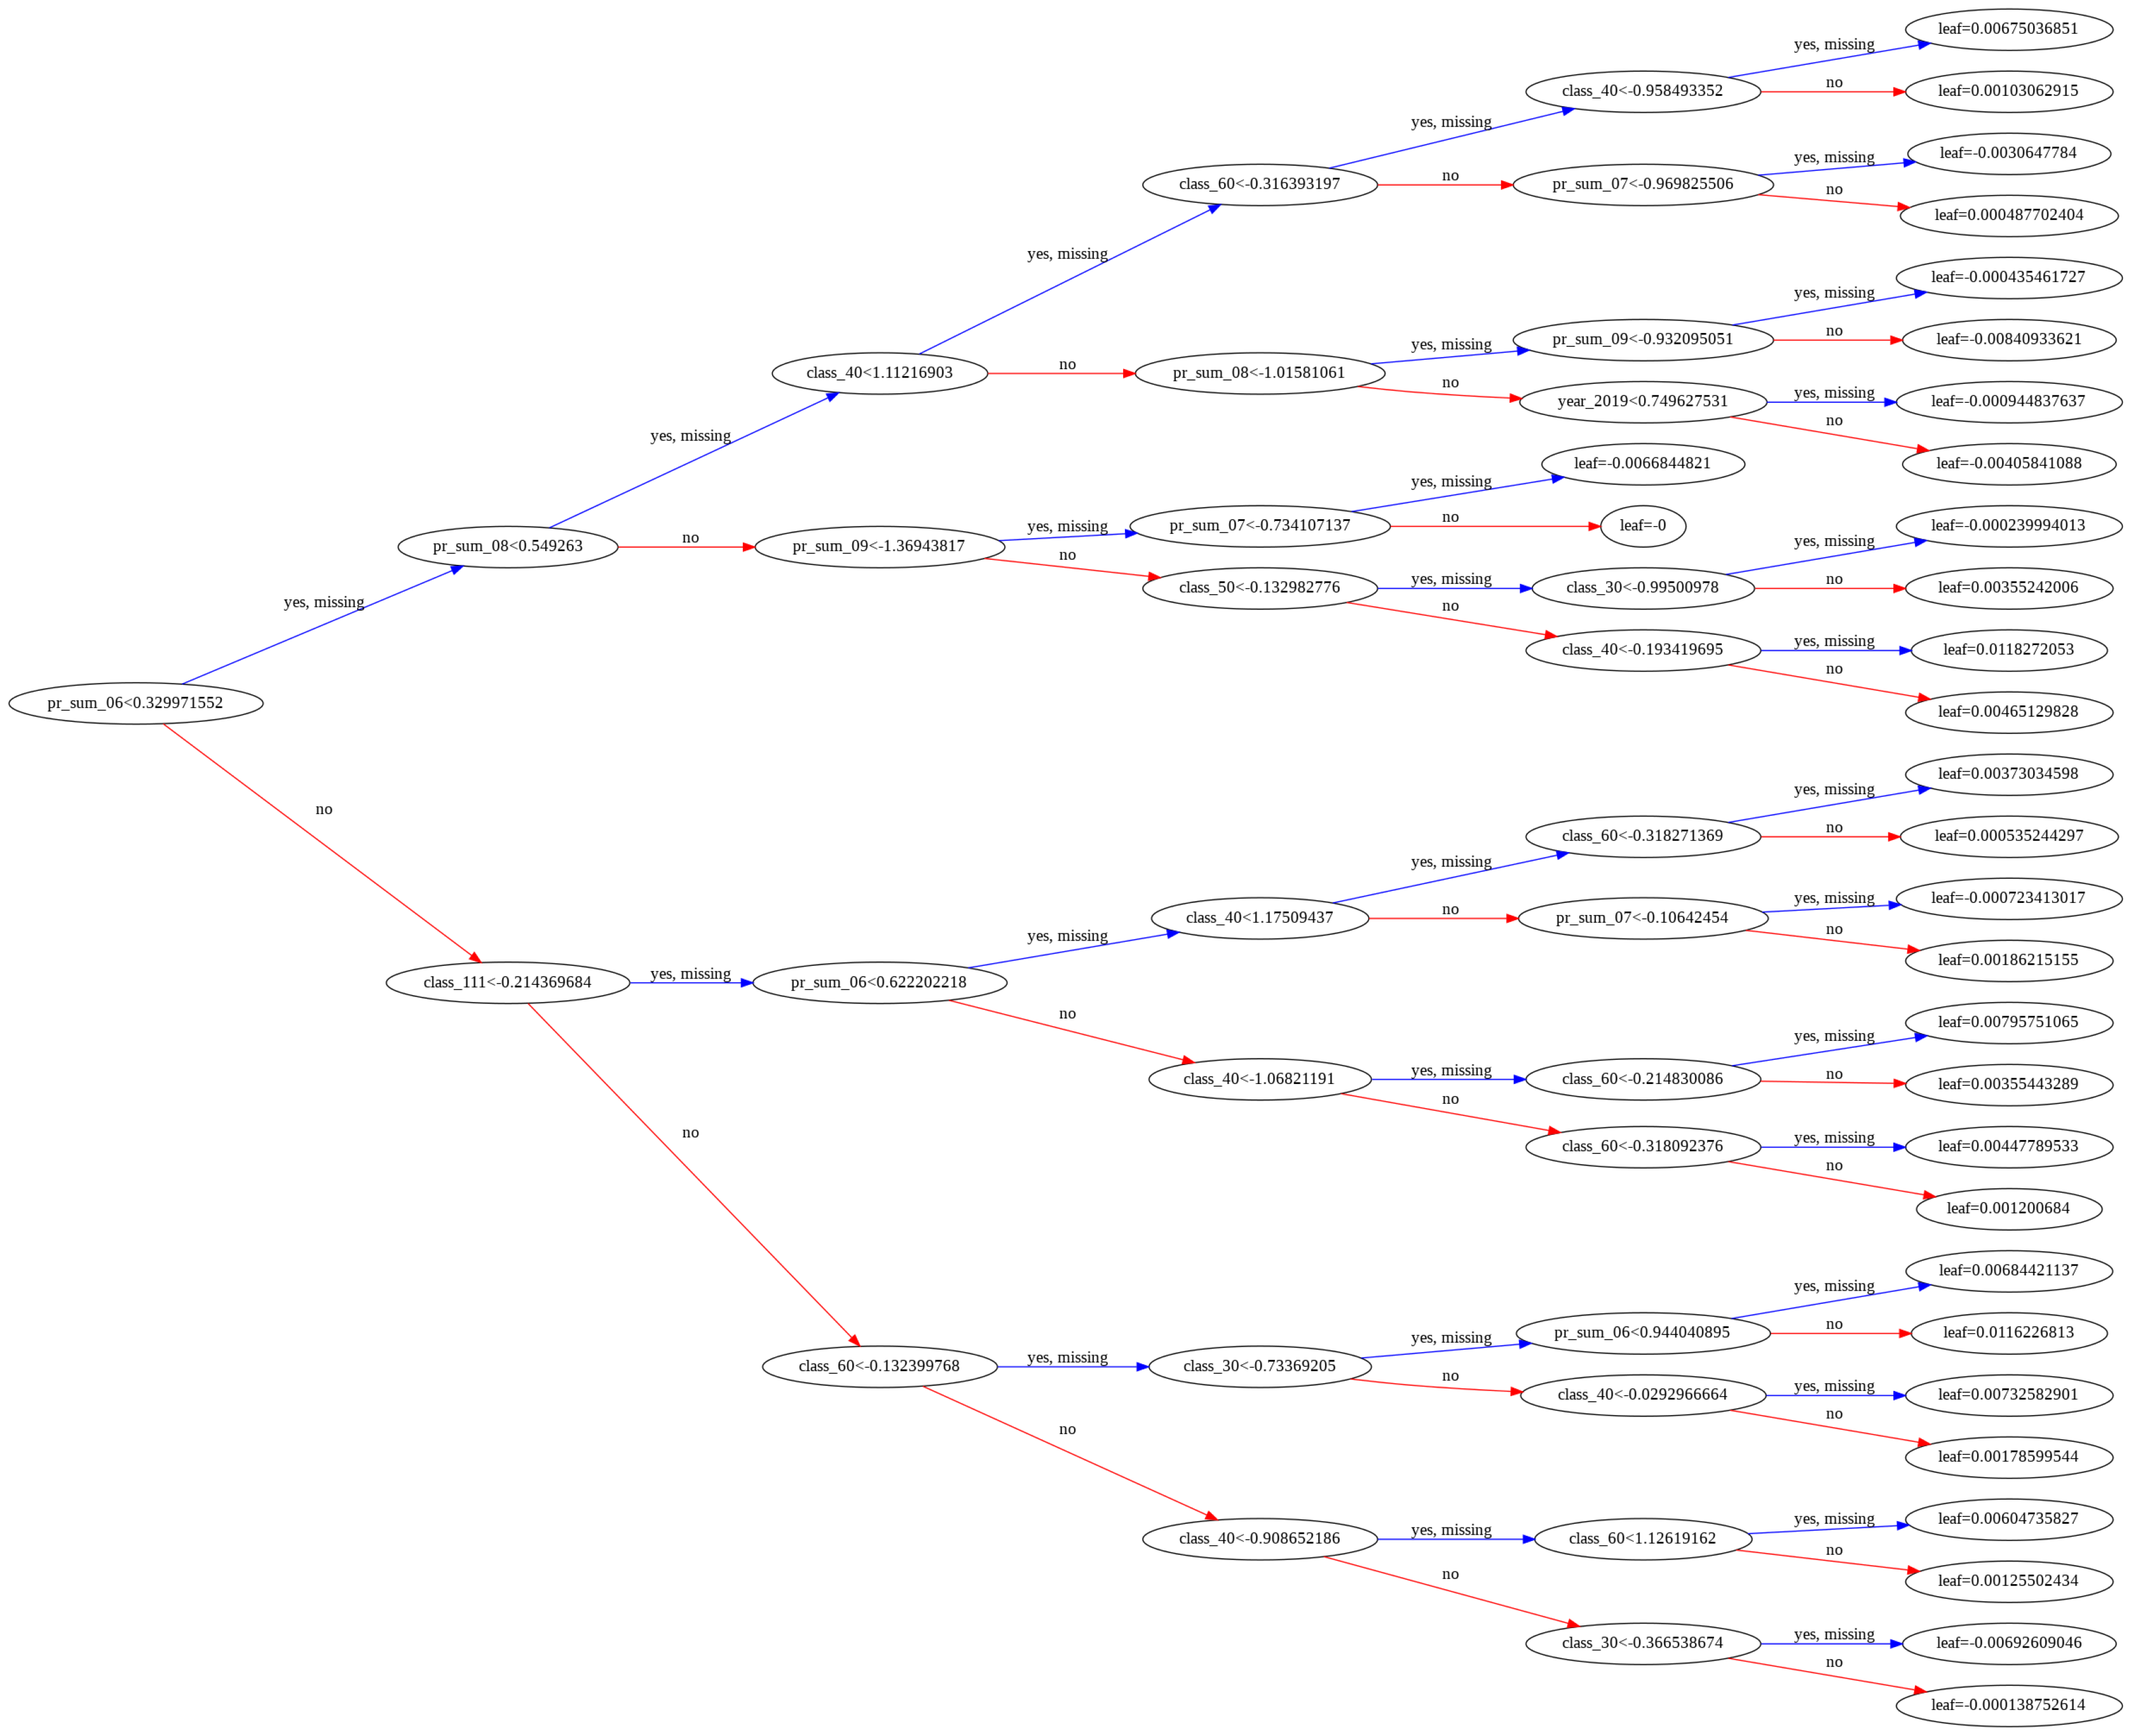

In [77]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
#set up the parameters
rcParams['figure.figsize'] = 80,50
xgboost.plot_tree(model_bo, num_trees=10, rankdir='LR')

plt.show()

In [78]:
# Shrub, (20)
# Herbaceous vegetation, (30)
# Cultivated and managed vegetation / agriculture (40)
# Settlements (50)
# bare/sparse vegetation (60)
# open water (80)
# Herbaceous wetland (90)
# Closed forest (111-126)


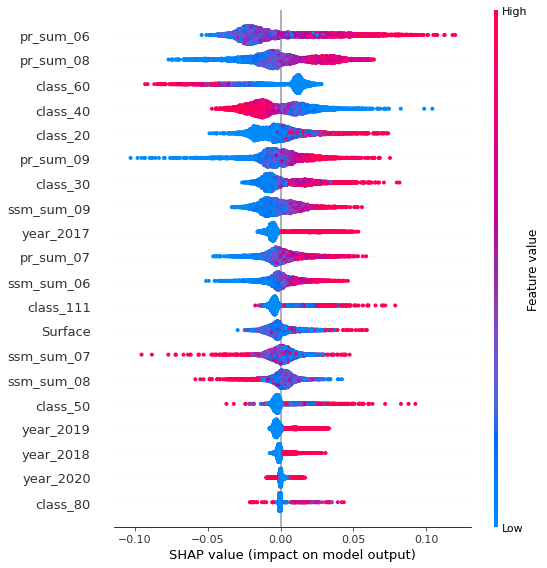

In [79]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_bo)
shap_values = explainer.shap_values(X_test[var_bo])
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test[var_bo])

# NN

In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


In [81]:
var_nn = years+  agg_m + build_up

In [82]:
horsepower = np.array(X_train[var_nn])

horsepower_normalizer = preprocessing.Normalization(input_shape=[len(var_nn),])
horsepower_normalizer.adapt(horsepower)

model_nn = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(64, activation="relu", name="layer1"),
    layers.Dense(32, activation="relu", name="layer2"),
    layers.Dense(32, activation="relu", name="layer4"),
    layers.Dense(16, activation="relu", name="layer3"),
    layers.Dense(units=1)
])

model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 20)                41        
_________________________________________________________________
layer1 (Dense)               (None, 64)                1344      
_________________________________________________________________
layer2 (Dense)               (None, 32)                2080      
_________________________________________________________________
layer4 (Dense)               (None, 32)                1056      
_________________________________________________________________
layer3 (Dense)               (None, 16)                528       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 5,066
Trainable params: 5,025
Non-trainable params: 41
_____________________________________________________

In [83]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

lr = .0005
opt = Adam(lr=lr, decay=lr/100)

model_nn.compile(loss='mean_squared_error',optimizer=opt)
early_stopping = EarlyStopping(patience = 5)

model_nn.fit(x = X_train[var_nn], y = y_train,\
                validation_data = (X_val[var_nn], y_val), \
                epochs = 150, batch_size = 64, shuffle = True, \
                callbacks = [early_stopping])

Epoch 1/150
689/689 [==============================] - 2s 2ms/step - loss: 0.0381 - val_loss: 0.0106
Epoch 2/150
689/689 [==============================] - 1s 2ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 3/150
689/689 [==============================] - 1s 2ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 4/150
689/689 [==============================] - 1s 2ms/step - loss: 0.0082 - val_loss: 0.0088
Epoch 5/150
689/689 [==============================] - 1s 2ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 6/150
689/689 [==============================] - 1s 2ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 7/150
689/689 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0079
Epoch 8/150
689/689 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0081
Epoch 9/150
689/689 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0080
Epoch 10/150
689/689 [==============================] - 1s 2ms/step - loss: 0.0073 - val_lo

In [84]:
metrics(model_nn,X_train[var_nn],X_test[var_nn],y_train,y_test)

train MSE 0.005898313008632629
train MAE 0.05737222870770011
train pR2 0.6532510524041857

test MSE 0.00683306746069612
test MAE 0.062090086505136144
test pR2 0.5894372222291837


In [85]:
%%capture
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model_nn.predict, X_train[var_nn][:10])
shap_values = explainer.shap_values(X_test[var_nn][:2000], nsamples=5)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test[var_nn].iloc[0,:])

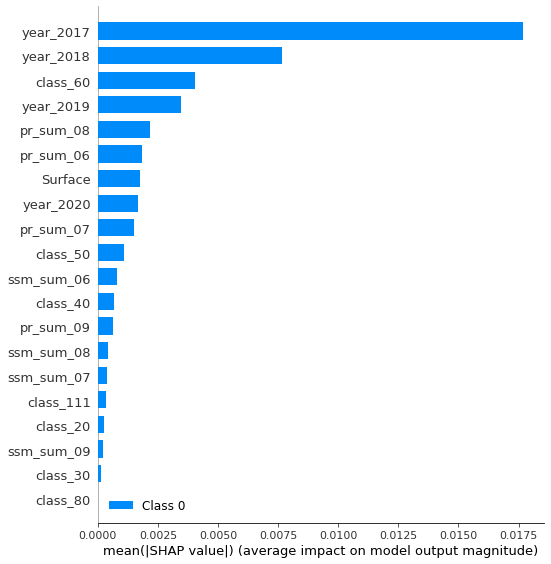

In [86]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test[var_nn][:2000])

# Deviants

In [87]:
X = X_train.append(X_val).append(X_test)
Y = y_train.append(y_val).append(y_test)

In [88]:
X[var_ols]

year_2017  year_2018  year_2019  ...  class_60  class_80   Surface
18687  -0.501852   1.995582  -0.500149  ... -0.318294 -0.119988 -0.177080
12043  -0.501852  -0.501107   1.999404  ... -0.318294 -0.119988  0.557108
29356   1.992621  -0.501107  -0.500149  ... -0.318294 -0.119988 -0.492104
31462  -0.501852   1.995582  -0.500149  ... -0.318294 -0.119988 -0.519499
47784  -0.501852  -0.501107  -0.500149  ... -0.318294 -0.119988 -0.352385
...          ...        ...        ...  ...       ...       ...       ...
23855  -0.501852  -0.501107  -0.500149  ... -0.318294 -0.119988 -0.308177
46906   1.992621  -0.501107  -0.500149  ... -0.142166 -0.119988 -0.345567
48140  -0.501852  -0.501107  -0.500149  ... -0.318294 -0.119988 -0.504325
3327   -0.501852   1.995582  -0.500149  ... -0.318294 -0.119988 -0.501550
47018  -0.501852  -0.501107   1.999404  ... -0.318294 -0.119988 -0.222716

[55043 rows x 20 columns]

In [89]:
pred_ols = ols.predict(sm.add_constant(X[var_ols]))
X['dev_ols'] = Y - pred_ols

pred_bo = model_bo.predict(X[var_bo])
X['dev_bo'] = Y - pred_bo

#pred_nn = model_nn.predict(X[var_nn])
#X['dev_nn'] = Y - pred_nn

In [90]:
X_dev = X.merge(df[['Village','geometry']],on='Village')

You are merging on int and float columns where the float values are not equal to their int representation


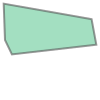

In [91]:
X_dev.geometry.iloc[42]

In [93]:
X_dev = X_dev.sort_values('dev_bo', axis=0, ascending=False)
X_dev[:5]

pr_sum_  ...                                           geometry
16260 -1.373150  ...  POLYGON ((2.036261421238505 15.00008829996953,...
28727 -1.127871  ...  POLYGON ((8.886288505242799 14.79243799954886,...
23104 -0.342901  ...  POLYGON ((5.799694048518421 14.9822575677994, ...
31554 -1.043488  ...  POLYGON ((5.307981989341716 15.09212043661111,...
26732 -0.501211  ...  POLYGON ((1.831945105146472 14.60202838467185,...

[5 rows x 32 columns]

In [96]:
import geopandas
gdf = geopandas.GeoDataFrame(
    X_dev, geometry=X_dev.geometry)

gdf = gdf.set_crs(epsg=4326, inplace=True)

In [97]:
x = X_dev.geometry.iloc[42].centroid.x
y = X_dev.geometry.iloc[42].centroid.y

In [98]:
import folium

m = folium.Map([y, x], zoom_start=11)
#folium.GeoJson(m_aoi_ucu).add_to(m)
folium.GeoJson(gdf[:50]).add_to(m)
m